In [1]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import skimage.draw
import random

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
DEVICE = "/cpu:0"

In [3]:
import coco_custom as cocox
config = cocox.CocoConfig()
COCO_DIR = "dataset"  # TODO: enter value here

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Deteccion en Test

In [6]:
# Validation dataset
dataset_val = cocox.CustomDataset()
dataset_val.load_custom(COCO_DIR, "inference")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
{'adelholzener_alpenquelle_classic_075': 1, 'adelholzener_alpenquelle_naturell_075': 2, 'adelholzener_classic_bio_apfelschorle_02': 3, 'adelholzener_classic_naturell_02': 4, 'adelholzener_gourmet_mineralwasser_02': 5, 'augustiner_lagerbraeu_hell_05': 6, 'augustiner_weissbier_05': 7, 'coca_cola_05': 8, 'coca_cola_light_05': 9, 'suntory_gokuri_lemonade': 10, 'tegernseer_hell_03': 11, 'corny_nussvoll': 12, 'corny_nussvoll_single': 13, 'corny_schoko_banane': 14, 'corny_schoko_banane_single': 15, 'dr_oetker_vitalis_knuspermuesli_klassisch': 16, 'koelln_muesli_fruechte': 17, 'koelln_muesli_schoko': 18, 'caona_cocoa': 19, 'cocoba_cocoa': 20, 'cafe_wunderbar_espresso': 21, 'douwe_egberts_professional_ground_coffee': 22, 'gepa_bio_caffe_crema': 23, 'gepa_italienischer_bio_espresso': 24, 'apple_braeburn_bundle': 25, 'apple_golden_delicious': 26, 'apple_granny_smith': 27, 'apple_red_boskoop': 28, 'avocado': 29, 'ba

In [7]:
model_inf = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
weights_path = model_inf.find_last()

# Load weights
print("Loading weights ", weights_path)
model_inf.load_weights(weights_path, by_name=True)

Loading weights  /home/COliveraC/mask-r-cnn/Mask_RCNN/logs/coco20221115T0707/mask_rcnn_coco_0040.h5





2022-11-17 06:56:52.882533: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-11-17 06:56:52.891808: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2022-11-17 06:56:52.893639: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561b4529c020 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-17 06:56:52.893681: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-17 06:56:52.896455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


2022-11-17 06:56:53.244793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 06:56:53.246548: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561b44da82b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-17 06:56:53.246583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-11-17 06:56:53.247016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 06:56:53.248526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2022-11-17 06:56:53.248916


Re-starting from epoch 40


dataset/inference/D2S_062905.jpg
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2022-11-17 06:57:00.132757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-17 06:57:00.299587: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


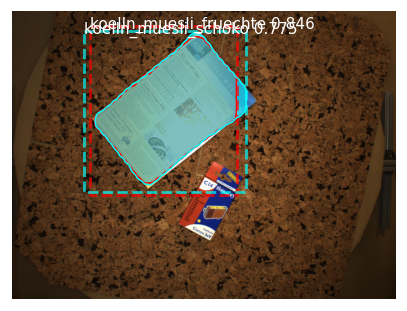

dataset/inference/D2S_063008.jpg
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


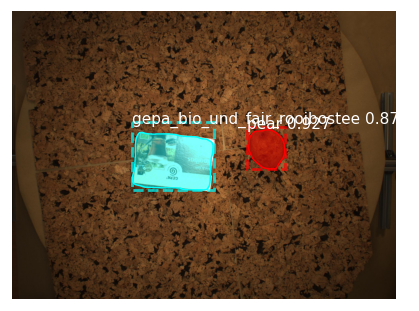

dataset/inference/D2S_000403.jpg
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


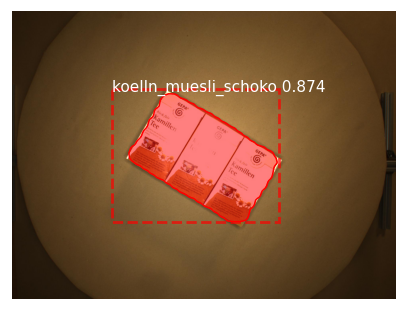

dataset/inference/D2S_062203.jpg
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


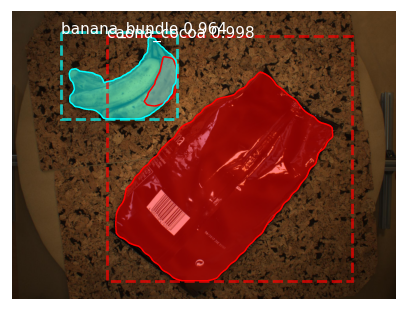

dataset/inference/D2S_067827.jpg
Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


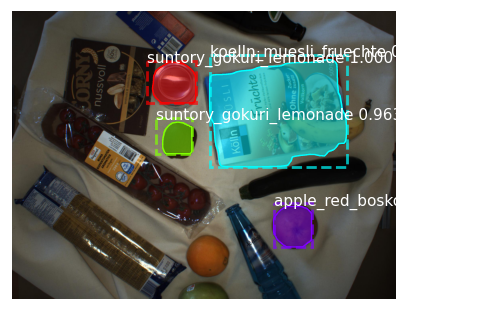

In [9]:
import skimage
import matplotlib.pyplot as plt

real_test_dir = 'dataset/inference/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    if img.ndim != 3:
      image = skimage.color.gray2rgb(img)
    elif img.shape[-1] == 4:
      image = img[..., :3]
    else:
      image = img

    print(image_path)
    img_arr = np.array(image)
    results = model_inf.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))